## Create a Backtesting System to Test a Mean-Reverting Trading Strategy: 
###  If the std of returns over an elapsed number of days is far from zero mean by a threshold, a buy/sell signal is generated. Here we use Goldman Sachs historical closing prices.

In [1]:
### Class to store tick data
class TickData(object):
    def __init__(self,timestamp='',symbol='',open_price=0,close_price=0,total_volume=0):
        self.symbol=symbol
        self.timestamp=timestamp
        self.open_price=open_price
        self.close_price=close_price
        self.total_volume=total_volume

In [2]:
### Class to store market data (most recent tick data)
class MarketData(object):
    def __init__(self):
        self.recent_ticks=dict()
    def add_tick_data(self,tick_data):
        self.recent_ticks[tick_data.symbol]=tick_data
    def get_open_price(self,symbol):
        return self.get_tick_data(symbol).open_price
    def get_close_price(self,symbol):
        return self.get_tick_data(symbol).close_price
    def get_tick_data(self,symbol):
        return self.recent_ticks.get(symbol,TickData())
    def get_timestamp(self,symbol):
        return self.recent_ticks[symbol].timestamp

In [3]:
### Class to generate sources of market data, Here we use Quandl as data provider
class MarketDataSource(object):
    def __init__(self,symbol,tick_event_handler=None,start='',end=''):
        self.market_data=MarketData()
        self.symbol=symbol
        self.tick_event_handler=tick_event_handler
        self.start,self.end=start,end
        self.df=None
    def fetch_historical_prices(self):
        import quandl
        QUANDL_API_KEY='yzcRLefPxvrTHdJ6_WPT'
        quandl.ApiConfig.api_key=QUANDL_API_KEY
        df=quandl.get(self.symbol,start_date=self.start, end_date=self.end)
        return df
    def run(self):
        if self.df is None:
            self.df=self.fetch_historical_prices()
        total_ticks=len(self.df)
        print('Processing total_ticks:',total_ticks)
        
        for timestamp,row in self.df.iterrows():
            open_price=row['Open']
            close_price=row['Close']
            volume=row['Volume']
            print(timestamp.date(),'TICK',self.symbol,'open:',open_price,'close:',close_price)
            tick_data=TickData(timestamp,self.symbol, open_price,close_price,volume)
            self.market_data.add_tick_data(tick_data)
            if self.tick_event_handler:
                self.tick_event_handler(self.market_data)
            

In [4]:
### Class for order, here we only use market orders
class Order(object):
    def __init__(self,timestamp,symbol,qty,is_buy,is_market_order,price=0):
        self.timestamp=timestamp
        self.symbol=symbol
        self.qty=qty
        self.price=price
        self.is_buy=is_buy
        self.is_market_order=is_market_order
        self.is_filled=False
        self.filled_price=0
        self.filled_time=None
        self.filled_qty=0
        


In [5]:
### Class for track positions, if a security is bought, the value of it will be debited from this account
class Position(object):
    def __init__(self,symbol=''):
        self.symbol=symbol
        self.buys=self.sells=self.net=0
        self.rpnl=0
        self.position_value=0
    def on_position_event(self,is_buy,qty,price):
        if is_buy:
            self.buys+=qty
        else: 
            self.sells+=qty
        self.net=self.buys-self.sells 
        changed_value=qty*price*(-1 if is_buy else 1)
        self.position_value+=changed_value
        if self.net==0:
            self.rpnl=self.position_value
            self.position_value=0 # when the net position is 0, the position is closed out, we get current pnl
    def calculate_unrealized_pnl(self,price): # in the case of a open position
        if self.net==0:
            return 0
        market_value=self.net*price
        upnl=self.position_value+market_value
        return upnl

In [6]:
### Class for an abstract strategy
from abc import abstractmethod
class Strategy:
    def __init__(self,send_order_event_handler):
        self.send_order_event_handler=send_order_event_handler
    @abstractmethod
    def on_tick_event(self,market_data):
        raise NotImplementedError('Method is Required.')
    @abstractmethod
    def on_position_event(self,positions):
        raise NotImplementedError('Method is Required.')
    def send_market_order(self,symbol,qty,is_buy,timestamp):
        if self.send_order_event_handler:
            order=Order(timestamp,symbol,qty,is_buy,is_market_order=True,price=0)
            self.send_order_event_handler(order)

In [13]:
### Class for mean-reverting strategy on APPL
import pandas as pd
class MeanRevertingStrategy(Strategy):
    def __init__(self,symbol,trade_qty,send_order_event_handler=None, lookback_intervals=20,buy_threshold=-1.5,sell_threshold=1.5):
        super(MeanRevertingStrategy,self).__init__(send_order_event_handler)
        self.symbol=symbol
        self.trade_qty=trade_qty
        self.lookback_intervals=lookback_intervals
        self.buy_threshold=buy_threshold
        self.sell_threshold=sell_threshold
        self.prices=pd.DataFrame()
        self.is_long=self.is_short=False
    def on_position_event(self,positions):
        position=positions.get(self.symbol)
        self.is_long=position and position.net>0
        self.is_short=position and position.net<0
    def on_tick_event(self,market_data):
        self.store_prices(market_data)
        if len(self.prices)<self.lookback_intervals:
            return 
        self.generate_signals_and_send_order(market_data)
    def store_prices(self,market_data):
        timestamp=market_data.get_timestamp(self.symbol)
        close_price=market_data.get_close_price(self.symbol)
        self.prices.loc[timestamp,'close']=close_price
    def generate_signals_and_send_order(self,market_data):
        signal_value=self.calculate_z_score()
        timestamp=market_data.get_timestamp(self.symbol)
        if self.buy_threshold>signal_value and not self.is_long:
            print(timestamp.date(),'Buy signal')
            self.send_market_order(self.symbol,self.trade_qty,True,timestamp)
        elif self.sell_threshold<signal_value and not self.is_short:
            print(timestamp.date(),'Sell signal')
            self.send_market_order(self.symbol,self.trade_qty,False,timestamp)
    def calculate_z_score(self):
        self.prices=self.prices[-self.lookback_intervals:]
        returns=self.prices['close'].pct_change().dropna()
        z_score=((returns-returns.mean())/returns.std())[-1]
        return z_score

In [14]:
### Build models with a backtesting engine
class BacktestEngine:
    def __init__(self,symbol,trade_qty,start='',end=''):
        self.symbol=symbol
        self.trade_qty=trade_qty
        self.market_data_source=MarketDataSource(symbol,tick_event_handler=self.on_tick_event,start=start,end=end)
        self.strategy=None
        self.unfilled_orders=[]
        self.positions=dict()
        self.df_rpnl=None
    def start(self,**kwargs):
        print('Backtest started...')
        self.unfilled_orders=[]
        self.positions=dict()
        self.df_rpnl=pd.DataFrame()
        self.strategy=MeanRevertingStrategy(self.symbol,self.trade_qty,send_order_event_handler=self.on_order_received,**kwargs)
        self.market_data_source.run()
        print('Backtest completed.')
    def on_order_received(self,order):
        print(order.timestamp.date(),'ORDER','BUY' if order.is_buy else 'SELL',order.symbol,order.qty)
        self.unfilled_orders.append(order)
    def on_tick_event(self,market_data):
        self.match_order_book(market_data)
        self.strategy.on_tick_event(market_data)
        self.print_position_status(market_data)
    def match_order_book(self,market_data):
        if len(self.unfilled_orders)>0:
            self.unfilled_order=[order for order in self.unfilled_orders if self.match_unfilled_orders(order,market_data)]
    def match_unfilled_orders(self,order,market_data):
        symbol=order.symbol
        timestamp=market_data.get_timestamp(symbol)
        # order is matched and filled
        if order.is_market_order and timestamp>order.timestamp:
            open_price=market_data.get_open_price(symbol)
            order.is_filled=True
            order.filled_timestamp=timestamp
            order.filled_price=open_price
            self.on_order_filled(symbol,order.qty,order.is_buy,open_price,timestamp)
            return False
        return True
    def on_order_filled(self,symbol,qty,is_buy,filled_price,timestamp):
        position=self.get_position(symbol)
        position.on_position_event(is_buy,qty,filled_price)
        self.df_rpnl.loc[timestamp,'rpnl']=position.rpnl
        self.strategy.on_position_event(self.positions)
        print(timestamp.date(),'FILLED','BUY' if is_buy else'SELL',qty,symbol,'at',filled_price)
    def get_position(self,symbol):
        if symbol not in self.positions:
            self.positions[symbol]=Position(symbol)
        return self.positions[symbol]
    def print_position_status(self,market_data):
        for symbol,position in self.positions.items():
            close_price=market_data.get_close_price(symbol)
            timestamp=market_data.get_timestamp(symbol)
            upnl=position.calculate_unrealized_pnl(close_price)
            print(timestamp.date(),'POSITION','value:%.3f' % position.position_value,
                 'upnl:%.3f' % upnl,'rpnl:%.3f' % position.rpnl)

## Running the Engine!!!

In [15]:
engine=BacktestEngine('WIKI/GS',1,start='2015-01-01',end='2017-12-31')
engine.start(lookback_intervals=20,buy_threshold=-1.5,sell_threshold=1.5)
# use the most recent 20 days price for calaulating Z value
# long when Z value goes below -1.5

Backtest started...
Processing total_ticks: 754
2015-01-02 TICK WIKI/GS open: 195.3 close: 194.41
2015-01-05 TICK WIKI/GS open: 193.06 close: 188.34
2015-01-06 TICK WIKI/GS open: 188.3 close: 184.53
2015-01-07 TICK WIKI/GS open: 186.85 close: 187.28
2015-01-08 TICK WIKI/GS open: 189.35 close: 190.27
2015-01-09 TICK WIKI/GS open: 190.48 close: 187.35
2015-01-12 TICK WIKI/GS open: 187.36 close: 185.07
2015-01-13 TICK WIKI/GS open: 186.58 close: 184.93
2015-01-14 TICK WIKI/GS open: 181.18 close: 180.23
2015-01-15 TICK WIKI/GS open: 180.18 close: 178.49
2015-01-16 TICK WIKI/GS open: 176.73 close: 177.23
2015-01-20 TICK WIKI/GS open: 177.57 close: 175.63
2015-01-21 TICK WIKI/GS open: 174.55 close: 177.15
2015-01-22 TICK WIKI/GS open: 178.81 close: 182.04
2015-01-23 TICK WIKI/GS open: 181.43 close: 180.49
2015-01-26 TICK WIKI/GS open: 178.72 close: 180.42
2015-01-27 TICK WIKI/GS open: 177.24 close: 176.49
2015-01-28 TICK WIKI/GS open: 177.73 close: 173.05
2015-01-29 TICK WIKI/GS open: 173.18

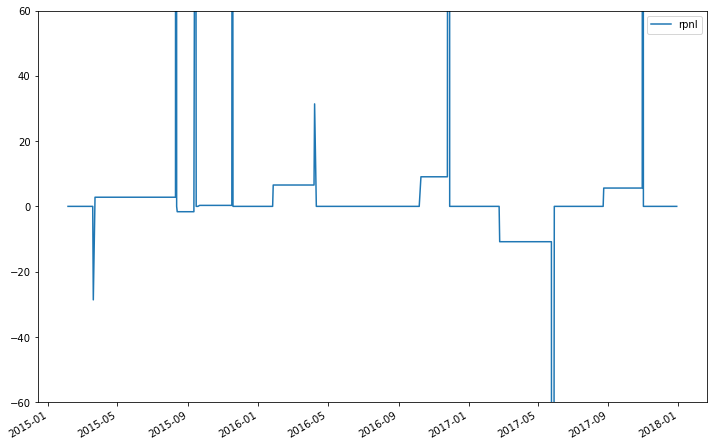

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
engine.df_rpnl.plot(ylim=[-60,60],figsize=(12,8));

### Multiple Runs to Find the Best Parameters

Backtest started...
Processing total_ticks: 754
2015-01-02 TICK WIKI/GS open: 195.3 close: 194.41
2015-01-05 TICK WIKI/GS open: 193.06 close: 188.34
2015-01-06 TICK WIKI/GS open: 188.3 close: 184.53
2015-01-07 TICK WIKI/GS open: 186.85 close: 187.28
2015-01-08 TICK WIKI/GS open: 189.35 close: 190.27
2015-01-09 TICK WIKI/GS open: 190.48 close: 187.35
2015-01-12 TICK WIKI/GS open: 187.36 close: 185.07
2015-01-13 TICK WIKI/GS open: 186.58 close: 184.93
2015-01-14 TICK WIKI/GS open: 181.18 close: 180.23
2015-01-15 TICK WIKI/GS open: 180.18 close: 178.49
2015-01-16 TICK WIKI/GS open: 176.73 close: 177.23
2015-01-20 TICK WIKI/GS open: 177.57 close: 175.63
2015-01-21 TICK WIKI/GS open: 174.55 close: 177.15
2015-01-22 TICK WIKI/GS open: 178.81 close: 182.04
2015-01-23 TICK WIKI/GS open: 181.43 close: 180.49
2015-01-26 TICK WIKI/GS open: 178.72 close: 180.42
2015-01-27 TICK WIKI/GS open: 177.24 close: 176.49
2015-01-28 TICK WIKI/GS open: 177.73 close: 173.05
2015-01-29 TICK WIKI/GS open: 173.18

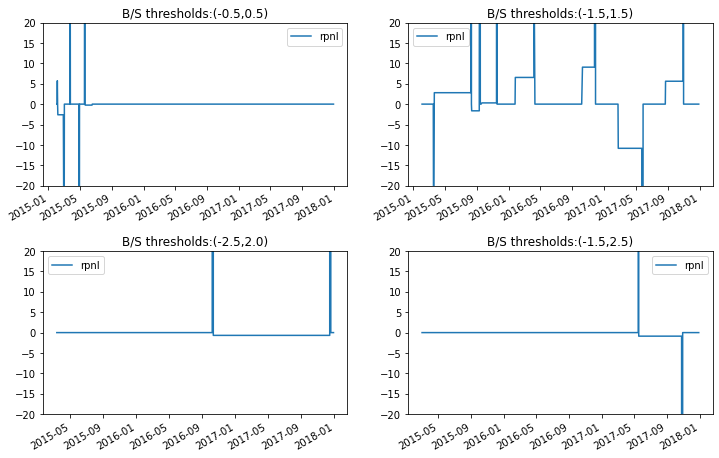

In [19]:
# Test and find the best threshold
THRESHOLDS=[(-0.5,0.5),(-1.5,1.5),(-2.5,2.0),(-1.5,2.5)]
%matplotlib inline
import matplotlib.pyplot as plt
fig,axes=plt.subplots(nrows=len(THRESHOLDS)//2,ncols=2,figsize=(12,8))
fig.subplots_adjust(hspace=0.4)
for i,(buy_threshold,sell_threshold) in enumerate(THRESHOLDS):
    engine.start(lookback_intervals=20,buy_threshold=buy_threshold,sell_threshold=sell_threshold)
    df_rnpls=engine.df_rpnl
    ax=axes[i//2,i%2]
    ax.set_title('B/S thresholds:(%s,%s)' %(buy_threshold,sell_threshold))
    df_rnpls.plot(ylim=[-20,20],ax=ax)


In [81]:
## A threshold of (-1.5,1.5) is optimal among the test set